In [1]:
#Importing all the req lib
!pip install shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00


In [3]:
# Load data
data = pd.read_csv('/content/ai4i2020.csv')

In [4]:
# Preprocessing the data
data['Type'] = data['Type'].astype('category').cat.codes

In [5]:
# Define features and target
X = data.drop(['UDI', 'Product ID', 'Machine failure'], axis=1)
y = data['Machine failure']

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
# Define model pipeline
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', RFECV(estimator=rf_model, step=1, cv=5)),
    ('classifier', rf_model)
])

In [9]:
# Hyperparameter tuning
pparam_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Reduced number of iterations
random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=pparam_dist,
    n_iter=10,  # Reduced number of iterations
    cv=3,       # Reduced number of folds
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

In [10]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Accuracy: 1.00
AUC: 0.99
F1-score: 0.99
Confusion Matrix:
[[2898    0]
 [   2  100]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2898
           1       1.00      0.98      0.99       102

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



Shape of shap_values: (3000, 10, 2)


<Figure size 1000x600 with 0 Axes>

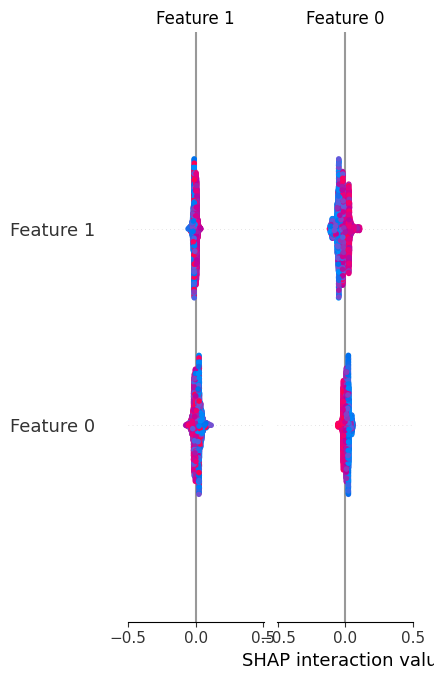

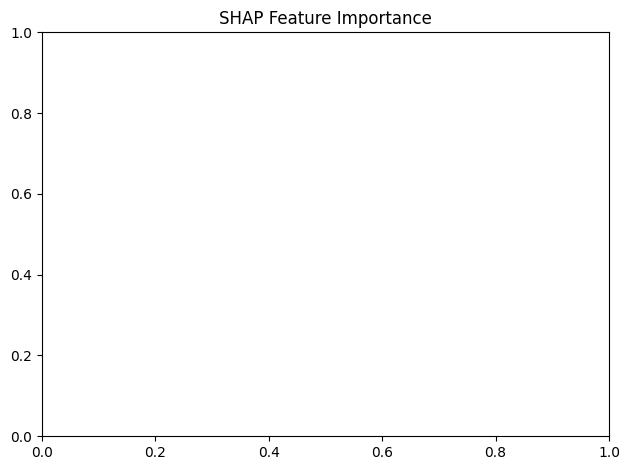

In [13]:
# Model interpretation using SHAP
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
# Transform the test data using the fitted pipeline
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)

print("Shape of shap_values:", shap_values.shape)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

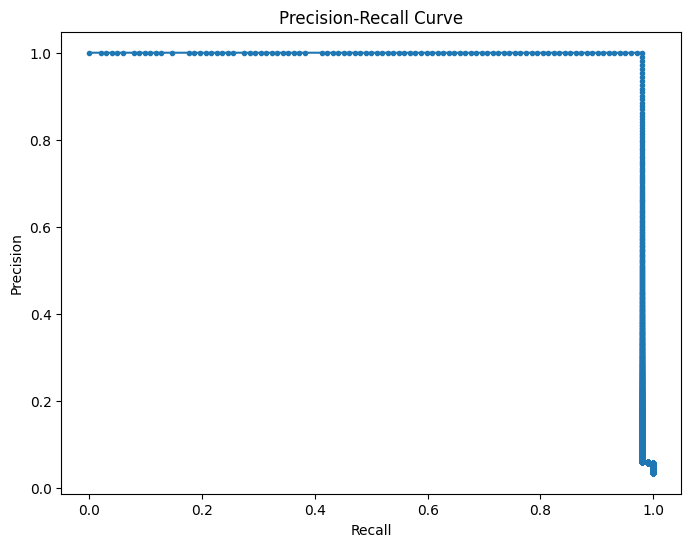

In [14]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [15]:
# Error analysis
def analyze_errors(X, y_true, y_pred, y_pred_proba):
    errors = X[y_true != y_pred].copy()
    errors['true_label'] = y_true[y_true != y_pred]
    errors['predicted_label'] = y_pred[y_true != y_pred]
    errors['prediction_probability'] = y_pred_proba[y_true != y_pred]
    return errors

error_df = analyze_errors(X_test, y_test, y_pred, y_pred_proba)
print("Sample of misclassified instances:")
print(error_df.head())

Sample of misclassified instances:
      Type  Air temperature [K]  Process temperature [K]  \
9015     1                297.2                    308.1   
8506     1                298.4                    309.6   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TWF  HDF  PWF  \
9015                    1431         49.7              210    0    0    0   
8506                    1710         27.3              163    0    0    0   

      OSF  RNF  true_label  predicted_label  prediction_probability  
9015    0    0           1                0                0.014952  
8506    0    0           1                0                0.013615  


In [16]:
def advanced_anomaly_detection(X_train, X_test):
    ee = EllipticEnvelope(contamination=0.01, random_state=42)
    ocsvm = OneClassSVM(kernel='rbf', nu=0.01) # Remove random_state
    iso_forest = IsolationForest(contamination=0.01, random_state=42)

    ee_anomalies = ee.fit(X_train).predict(X_test)
    ocsvm_anomalies = ocsvm.fit(X_train).predict(X_test)
    if_anomalies = iso_forest.fit(X_train).predict(X_test)

    combined_anomalies = ((ee_anomalies + ocsvm_anomalies + if_anomalies) < 0).astype(int)
    return combined_anomalies

In [17]:
# Perform anomaly detection
anomalies = advanced_anomaly_detection(X_train, X_test)
print(f"Number of anomalies detected: {sum(anomalies)}")

Number of anomalies detected: 14


In [18]:
# Real-time monitoring
def simulate_sensor_data(feature_names):
    return pd.DataFrame([np.random.rand(len(feature_names))], columns=feature_names)

In [19]:
def realtime_monitoring(model, preprocessor, threshold, X, simulation_time=60):
    start_time = time.time()
    feature_names = X.columns
    while time.time() - start_time < simulation_time:
        new_data = simulate_sensor_data(feature_names)
        processed_data = preprocessor.transform(new_data)
        failure_prob = model.named_steps['classifier'].predict_proba(processed_data)[0, 1]
        if failure_prob >= threshold:
            print(f"Alert: High failure probability detected! {failure_prob:.2f}")
        time.sleep(1)

In [20]:
# Usage
print("Starting real-time monitoring simulation...")
realtime_monitoring(best_model, best_model.named_steps['preprocessor'], 0.7, X, simulation_time=10)
print("Real-time monitoring simulation completed.")

Starting real-time monitoring simulation...
Alert: High failure probability detected! 0.76
Alert: High failure probability detected! 0.93
Alert: High failure probability detected! 0.97
Alert: High failure probability detected! 0.96
Alert: High failure probability detected! 0.90
Alert: High failure probability detected! 0.83
Alert: High failure probability detected! 0.89
Alert: High failure probability detected! 0.97
Alert: High failure probability detected! 0.88
Alert: High failure probability detected! 0.77
Real-time monitoring simulation completed.


In [21]:
# Save the model
import joblib
joblib.dump(best_model, 'machine_failure_prediction_model.joblib')
print("Model saved as 'machine_failure_prediction_model.joblib'")
print("Script execution completed.")

Model saved as 'machine_failure_prediction_model.joblib'
Script execution completed.
